# Clustering project - Audi

### Načtení knihoven

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.cluster.hierarchy as clust_hier
import scipy.spatial
from sklearn.cluster import AgglomerativeClustering, DBSCAN

### Atributy tabulky

- model: model audi
- year registraion: rok registrace
- price: cena v eurech
- transmission: typ převodovky
- mileage: ujetých km
- fuelType: typ motoru
- tax: daň
- mpg: spotřeba (počet mílí na galón)
- engineSize: velikost motoru v litrech

### Nějaké hypotézy a předtuchy?

Předpokládám, že data budou odpovídat realitě - dražší auta budou ta, která mají menší ujetou vzdálenost a objemnější motory. Také si myslím, že auta s objemnějšími motory budou mít vyšší spotřebu a vyšší silniční daň. Bylo by hezké, kdyby se nám podařilo rozdělit ojetá auta podle ceny/ujeté vzdálenosti.

### Načtení tabulky

In [2]:
df = pd.read_csv('audi.csv')
pd.set_option('display.max_columns', None)
df.head()

model  year  price transmission  mileage fuelType  tax   mpg  engineSize
0    A1  2017  12500       Manual    15735   Petrol  150  55.4         1.4
1    A6  2016  16500    Automatic    36203   Diesel   20  64.2         2.0
2    A1  2016  11000       Manual    29946   Petrol   30  55.4         1.4
3    A4  2017  16800    Automatic    25952   Diesel  145  67.3         2.0
4    A3  2019  17300       Manual     1998   Petrol  145  49.6         1.0

### Úprava tabulky

In [3]:
def transmission(row):
    if row["transmission"] == "Manual":
        return 0
    elif row["transmission"] == "Automatic":
        return 1
    else:
        return 2

def fuelType(row):
    if row["fuelType"] == "Petrol":
        return 0
    elif row["fuelType"] == "Diesel":
        return 1
    else:
        return 2

df['transmission_val'] = df.apply(lambda row: transmission(row), axis=1)
df['fuelType_val'] = df.apply(lambda row: fuelType(row), axis=1)

df.head()

model  year  price transmission  mileage fuelType  tax   mpg  engineSize  \
0    A1  2017  12500       Manual    15735   Petrol  150  55.4         1.4   
1    A6  2016  16500    Automatic    36203   Diesel   20  64.2         2.0   
2    A1  2016  11000       Manual    29946   Petrol   30  55.4         1.4   
3    A4  2017  16800    Automatic    25952   Diesel  145  67.3         2.0   
4    A3  2019  17300       Manual     1998   Petrol  145  49.6         1.0   

   transmission_val  fuelType_val  
0                 0             0  
1                 1             1  
2                 0             0  
3                 1             1  
4                 0             0

- data zřejmě měnit není potřeba
- přidal jsem navíc číselné sloupce znázorňující typ převodovky (transmission) a fuelType - občas je potřeba pracovat s číselnými hodnotami

## Explorativní analýza

In [58]:
df.shape

(10668, 11)

- v tabulce je přes 10 tisíc záznamů o autech
- máme pouze 8 atributů (+ 1 pomocný)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   model             10668 non-null  object 
 1   year              10668 non-null  int64  
 2   price             10668 non-null  int64  
 3   transmission      10668 non-null  object 
 4   mileage           10668 non-null  int64  
 5   fuelType          10668 non-null  object 
 6   tax               10668 non-null  int64  
 7   mpg               10668 non-null  float64
 8   engineSize        10668 non-null  float64
 9   transmission_val  10668 non-null  int64  
 10  fuelType_val      10668 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 916.9+ KB


- v tabulce jsou převážně číselné hodnoty
- máme dva kategorické atributy (`transmission` a `fuelType`)

#### Číselné atributy

In [60]:
df.describe(include=np.number)

year          price        mileage           tax           mpg  \
count  10668.000000   10668.000000   10668.000000  10668.000000  10668.000000   
mean    2017.100675   22896.685039   24827.244001    126.011436     50.770022   
std        2.167494   11714.841888   23505.257205     67.170294     12.949782   
min     1997.000000    1490.000000       1.000000      0.000000     18.900000   
25%     2016.000000   15130.750000    5968.750000    125.000000     40.900000   
50%     2017.000000   20200.000000   19000.000000    145.000000     49.600000   
75%     2019.000000   27990.000000   36464.500000    145.000000     58.900000   
max     2020.000000  145000.000000  323000.000000    580.000000    188.300000   

         engineSize  transmission_val  fuelType_val  
count  10668.000000      10668.000000  10668.000000  
mean       1.930709          0.927072      0.528028  
std        0.602957          0.860760      0.504468  
min        0.000000          0.000000      0.000000  
25%        1.500000          0.000000      0.000000  
50%        2.000000          1.000000      1.000000  
75%        2.000000          2.000000      1.000000  
max        6.300000          2.000000      2.000000

- průměrná cena ojetého auta je 22,8 tisíc eur
- průměrná ujetá vzdálenost auta je 24,8 tisíc mil

#### Kategorické atributy

In [61]:
cols_categories = df.select_dtypes(exclude={np.number}).columns
cols_categories

for col in cols_categories:
    print(col)
    print(df[col].unique().tolist())
    print()

model
[' A1', ' A6', ' A4', ' A3', ' Q3', ' Q5', ' A5', ' S4', ' Q2', ' A7', ' TT', ' Q7', ' RS6', ' RS3', ' A8', ' Q8', ' RS4', ' RS5', ' R8', ' SQ5', ' S8', ' SQ7', ' S3', ' S5', ' A2', ' RS7']

transmission
['Manual', 'Automatic', 'Semi-Auto']

fuelType
['Petrol', 'Diesel', 'Hybrid']



- zde jsou vypsány kategorické atributy, jedná se o (`transmission` a `fuelType`)
- všechny naše kategorické atributy kromě modelu mají pouze na výběr ze tří možností

#### Nulové hodnoty

In [62]:
print(df.shape)
print('\n')
print(df.isnull().count())
print('\n')
print(df.isna().count())

(10668, 11)


model               10668
year                10668
price               10668
transmission        10668
mileage             10668
fuelType            10668
tax                 10668
mpg                 10668
engineSize          10668
transmission_val    10668
fuelType_val        10668
dtype: int64


model               10668
year                10668
price               10668
transmission        10668
mileage             10668
fuelType            10668
tax                 10668
mpg                 10668
engineSize          10668
transmission_val    10668
fuelType_val        10668
dtype: int64


- v tabulce nejsou žádné nulové hodnoty

### Různé explorativní analýzy

#### Jaká jsou nejdražší ojetá auta?

In [63]:
df.sort_values(by="price", ascending=False).head(20)

model  year   price transmission  mileage fuelType  tax   mpg  \
4783     R8  2020  145000    Semi-Auto     2000   Petrol  145  21.1   
2255     R8  2020  137995    Semi-Auto       70   Petrol  145  21.1   
4179     R8  2019  137500    Semi-Auto       10   Petrol  150  21.4   
3367     R8  2019  135000    Automatic     1000   Petrol  145  32.8   
5459     R8  2020  133900    Semi-Auto      333   Petrol  145  21.4   
1646     R8  2019  129000    Semi-Auto     4000   Petrol  145  21.4   
10468    R8  2019  125000    Automatic    13663   Petrol  150  21.4   
4925     R8  2019  125000    Semi-Auto      500   Petrol  145  21.4   
3359     R8  2019  125000    Automatic      100   Petrol  145  24.1   
7445     R8  2019  119995    Semi-Auto     7800   Petrol  145  21.4   
7128     R8  2019  119450    Automatic     3000   Petrol  145  21.4   
4742     R8  2019  117990    Automatic    11936   Petrol  145  21.4   
5707     R8  2019  116000    Automatic     2369   Petrol  145  22.6   
3939     R8  2019  112990    Automatic     8175   Petrol  145  21.6   
4954     R8  2019  109990    Automatic     6954   Petrol  145  21.6   
6384    RS6  2020  109495    Semi-Auto     1500   Petrol  150  22.1   
10225   RS6  2020  104948    Automatic     3000   Petrol  145  22.1   
4400    RS6  2020  102544    Semi-Auto     2000   Petrol  145  22.1   
3711    RS6  2020   97500    Semi-Auto     3220   Petrol  150  22.1   
8630     R8  2018   95950    Automatic     5044   Petrol  150  23.0   

       engineSize  transmission_val  fuelType_val  
4783          5.2                 2             0  
2255          5.2                 2             0  
4179          5.2                 2             0  
3367          5.2                 1             0  
5459          5.2                 2             0  
1646          5.2                 2             0  
10468         5.2                 1             0  
4925          5.2                 2             0  
3359          5.2                 1             0  
7445          5.2                 2             0  
7128          5.2                 1             0  
4742          5.2                 1             0  
5707          5.2                 1             0  
3939          5.2                 1             0  
4954          5.2                 1             0  
6384          4.0                 2             0  
10225         4.0                 1             0  
4400          4.0                 2             0  
3711          4.0                 2             0  
8630          5.2                 1             0

- mezi nejdražší model patří model "R8", také i "RS6"
- jedná se o auta, která mají najeté krátké vzdálenosti
- nejdražší ojeté auto je model R8 s cenou 145 tisíc eur a najetou vzdáleností 2000 mil
- nejdražší auta jsou v průměru ta, která mají velký objem motoru
- nejdražší auta jsou z velké většiny benzínová

#### Jaká jsou nejlevnější ojetá auta?

In [47]:
df.sort_values(by="price", ascending=True).head(20)

model  year  price transmission  mileage fuelType  tax   mpg  \
10588    A3  2003   1490    Automatic   101000   Diesel  240  44.5   
10552    A4  2004   1699       Manual   110000   Diesel  315  36.2   
7795     A3  2005   1975       Manual   104000   Petrol  240  38.1   
10108    TT  2002   1990       Manual   131925   Petrol  325  30.1   
7404     A3  2009   2490       Manual   152034   Diesel  150  55.4   
9822     A6  2008   2490       Manual   323000   Diesel  200  44.1   
10158    A2  2003   2490       Manual   100000   Diesel   30  65.7   
9897     A3  2005   2495       Manual   122000   Diesel  150  53.3   
9359     A6  2003   2495       Manual   129000   Diesel  325  31.7   
7750     A6  2003   2495    Automatic   117000   Diesel  290  39.8   
10259    A6  2007   2600       Manual   127700   Diesel  205  44.1   
9543     A4  2007   2675       Manual   125000   Petrol  305  34.9   
9634     A3  2007   2795       Manual   104000   Diesel  145  53.3   
9523     TT  2002   2876       Manual    99000   Petrol  295  30.1   
9895     TT  2004   2895       Manual   129000   Petrol  325  30.8   
10500    A3  2005   2895       Manual   106790   Petrol  240  35.3   
10179    A4  2005   2990       Manual    95000   Petrol  300  34.9   
9882     A3  2007   2995       Manual   128000   Diesel  200  48.7   
10516    A4  2006   2995       Manual   114000   Diesel  195  48.7   
9726     A3  2008   2995       Manual   136000   Diesel  205  48.7   

       engineSize  transmission_val  fuelType_val  cluster_id  
10588         1.9                 1             1           0  
10552         2.5                 0             1           0  
7795          2.0                 0             0           0  
10108         1.8                 0             0           0  
7404          1.9                 0             1           0  
9822          2.0                 0             1           0  
10158         1.4                 0             1           0  
9897          0.0                 0             1           0  
9359          2.5                 0             1           0  
7750          2.5                 1             1           0  
10259         2.0                 0             1           0  
9543          2.0                 0             0           0  
9634          1.9                 0             1           0  
9523          1.8                 0             0           0  
9895          1.8                 0             0           0  
10500         1.6                 0             0           0  
10179         2.0                 0             0           0  
9882          2.0                 0             1           0  
10516         2.0                 0             1           0  
9726          2.0                 0             1           0

- mezi nejlevnější modey patří různé modely, např. "A3", "A6" a "TT"
- jedná se o auta, která mají najeté velké vzdálenosti
- nejlevnější ojeté auto je model A3 s cenou pouhých 1490 eur a najetou vzdáleností 101 tisíc mil
- nejlevnější auta jsou v průměru ta, která mají manuální převodovku

#### Jaká jsou auta, která mají nejlepší spotřebu?

In [44]:
df.sort_values(by="mpg", ascending=False).head(20)

model  year  price transmission  mileage fuelType  tax    mpg  \
4493     A3  2014  15490    Automatic    24597   Hybrid    0  188.3   
3106     A3  2015  14981    Semi-Auto    28294   Hybrid    0  188.3   
10392    A3  2015  14000    Automatic    63000   Hybrid    0  188.3   
4879     A3  2014  15000    Semi-Auto    24597   Hybrid    0  188.3   
4261     A3  2015  17990    Automatic    14000   Hybrid    0  188.3   
10656    A3  2016  15495    Semi-Auto    52500   Hybrid    0  176.6   
5717     A3  2016  18900    Semi-Auto    18486   Hybrid    0  176.6   
10185    A3  2015  11240    Automatic    89000   Hybrid    0  176.6   
8875     A3  2015  11295    Automatic    72260   Hybrid    0  176.6   
8323     A3  2016  15499    Automatic    48573   Hybrid    0  176.6   
4559     A3  2015  16000    Semi-Auto    48954   Hybrid    0  176.6   
8570     A3  2015   9795    Automatic   121420   Hybrid    0  176.6   
10003    A3  2016  13000    Automatic    72800   Hybrid    0  176.6   
5981     Q7  2016  34999    Semi-Auto    36461   Diesel    0  156.9   
5666     Q7  2016  37999    Automatic    36461   Diesel    0  156.9   
2550     Q7  2017  32998    Semi-Auto    66477   Hybrid  140  156.9   
864      A3  2020  31990    Semi-Auto     2165   Hybrid  135  141.3   
6382     A3  2020  32495    Semi-Auto     7500   Hybrid  135  141.3   
3489     Q5  2019  44991    Semi-Auto     2010   Hybrid  135  117.7   
6307     Q5  2020  43900    Semi-Auto      500   Hybrid  135  117.7   

       engineSize  transmission_val  fuelType_val  cluster_id  
4493          1.4                 1             2           1  
3106          1.4                 2             2           1  
10392         1.4                 1             2           0  
4879          1.4                 2             2           1  
4261          1.4                 1             2           1  
10656         1.4                 2             2           0  
5717          1.4                 2             2           1  
10185         1.4                 1             2           0  
8875          1.4                 1             2           0  
8323          1.4                 1             2           0  
4559          1.4                 2             2           0  
8570          1.4                 1             2           0  
10003         1.4                 1             2           0  
5981          3.0                 2             1           1  
5666          3.0                 1             1           1  
2550          3.0                 2             2           0  
864           1.4                 2             2           2  
6382          1.4                 2             2           2  
3489          2.0                 2             2           2  
6307          2.0                 2             2           2

- nejmenší spotřebu mají především hybridy

#### Jaký model Audi je nejvíce zastoupen?

In [64]:
df.groupby("model").model.count().sort_values(ascending=False).head(10)

model
 A3    1929
 Q3    1417
 A4    1381
 A1    1347
 A5     882
 Q5     877
 Q2     822
 A6     748
 Q7     397
 TT     336
Name: model, dtype: int64

- největší zastoupení má model "A3" společně s "Q3", "A4" a "A1"

#### Jaké roky registrací převažují?

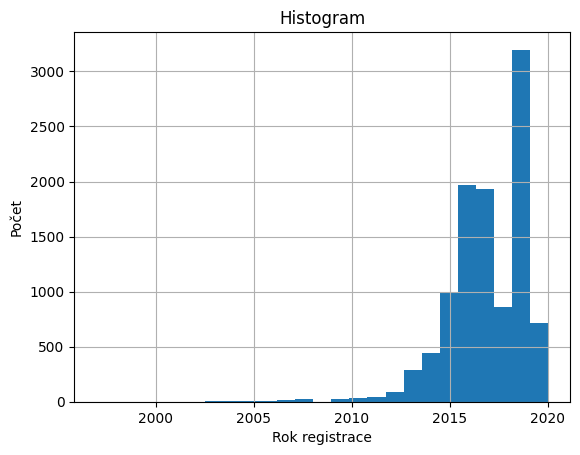

In [65]:
df["year"].hist(grid=True,bins=25)
plt.xlabel("Rok registrace")
plt.ylabel("Počet")
plt.title("Histogram")
plt.show()

- nejčastější rok registrace se pohybuje mezi 2015 - 2020

#### S jakými cenami pracujeme v tabulce?

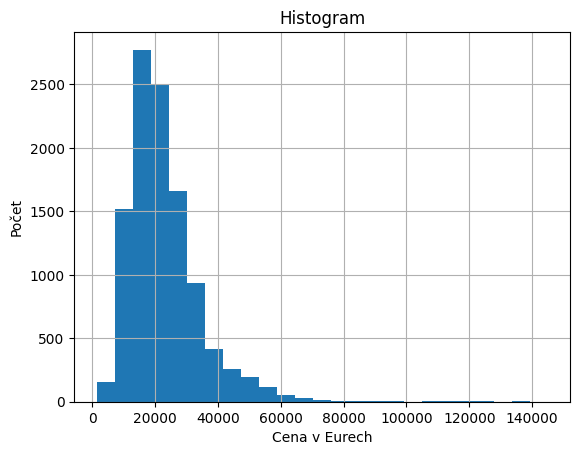

In [66]:
df["price"].hist(grid=True,bins=25)
plt.xlabel("Cena v Eurech")
plt.ylabel("Počet")
plt.title("Histogram")
plt.show()

- ceny ojetých vozů se nejčastěji pohybují mezi 15000 - 30000 eur

#### Je některý typ motoru více zastoupen?

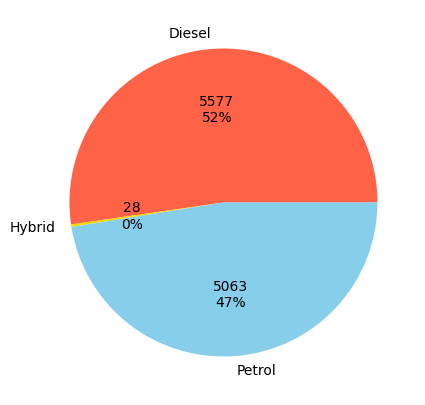

In [67]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

fig = plt.figure(figsize=(10, 5))
df.groupby('fuelType').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.show()

- mezi ojetými Audi auty se nenachází téměř žádné hybridní motory
- poměr mezi "Diesel" a "Petrol" motory je téměř vyrovnaný

#### Obsahuje tabulka nějaké souvislosti (korelace)?

/tmp/ipykernel_263/483730371.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df.corr()


<AxesSubplot: >

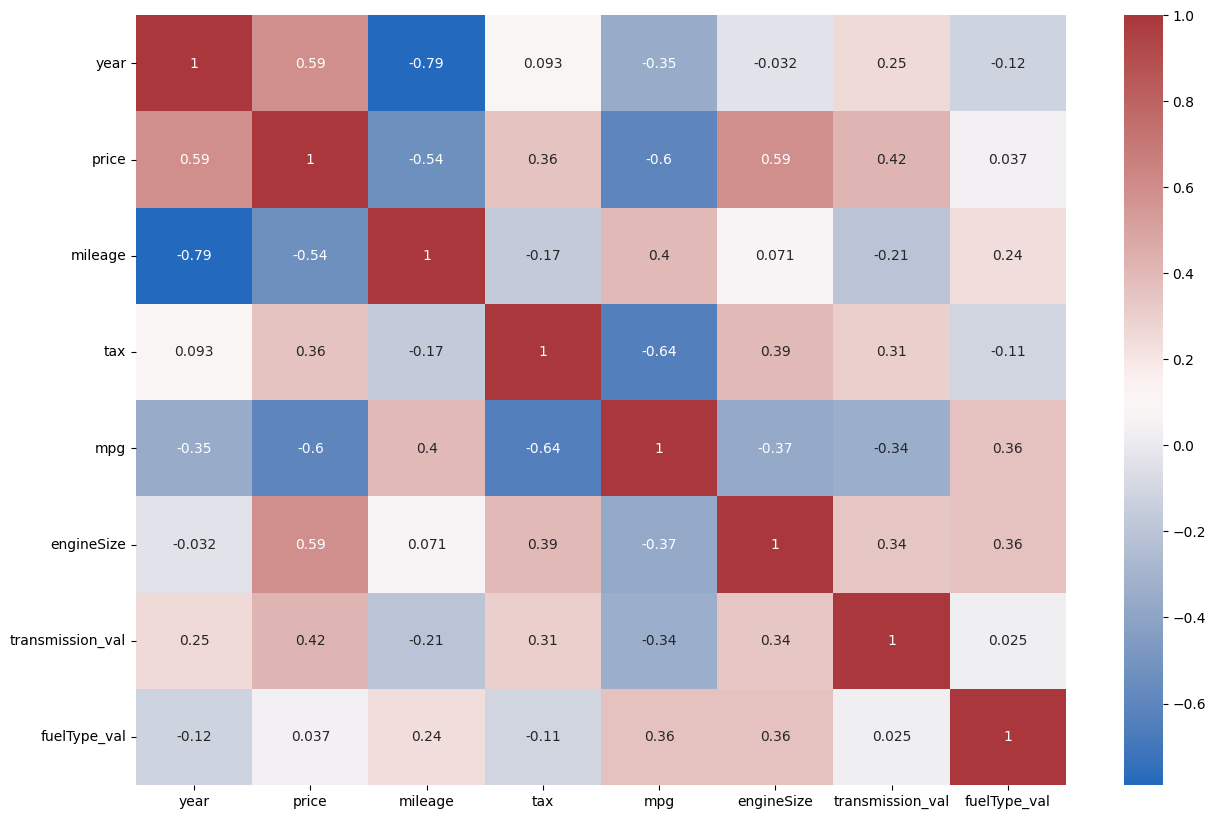

In [68]:
cor = df.corr()
fig = plt.figure(figsize = (15, 10))
sns.heatmap(cor, annot=True, cmap='vlag')

- atributy mezi sebou moc nekorelují
- jediná korelace, kterou lze zaznamenat, je závislost ceny na objemu motoru
- slabou korelaci lze také zaznamenat u typu převodovky a ceně
- naopak téměř žádná závislost není u roku registrace a najeté vzdálenosti

### Jaké jsou poměry motorů v různých typech převodovek?

<AxesSubplot: xlabel='Count', ylabel='transmission'>

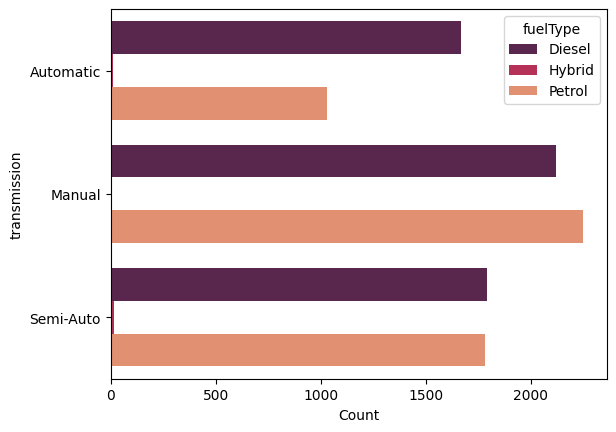

In [69]:
sns.barplot(data=df.groupby(['transmission', 'fuelType']).transmission.count().reset_index(name="Count"), y='transmission', x='Count', hue='fuelType', palette='rocket')

- poměry jsou celkem vyvážené
- jediná nevyváženost je u automatických převodovek
- velmi malé zastoupení mají hybridní auta

### Jaké jsou poměry motorů u různých modelů aut?

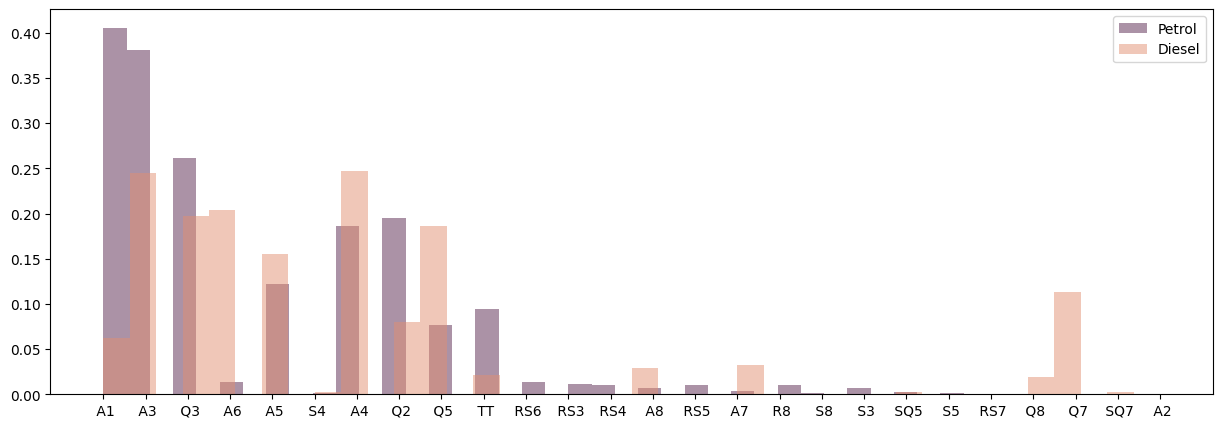

In [70]:
petrol = df[df.fuelType == "Petrol"].iloc[:,:1]
diesel = df[df.fuelType == "Diesel"].iloc[:,:1]

petrol = np.array(petrol)
diesel = np.array(diesel)

fig = plt.figure(figsize=(15, 5))
plt.hist(petrol, density=True, bins=40, color="#59274e",alpha=0.5, label="Petrol")
plt.hist(diesel,density=True, bins=40,color="#e29072",alpha=0.5, label="Diesel")
plt.legend(loc='upper right')
plt.show()

- na histogramu lze vidět u kterých modelů aut převládají auta na benzín nebo diesel

### Závisí nějak typ motoru na ujeté vzdálenosti?

<AxesSubplot: xlabel='fuelType', ylabel='mileage'>

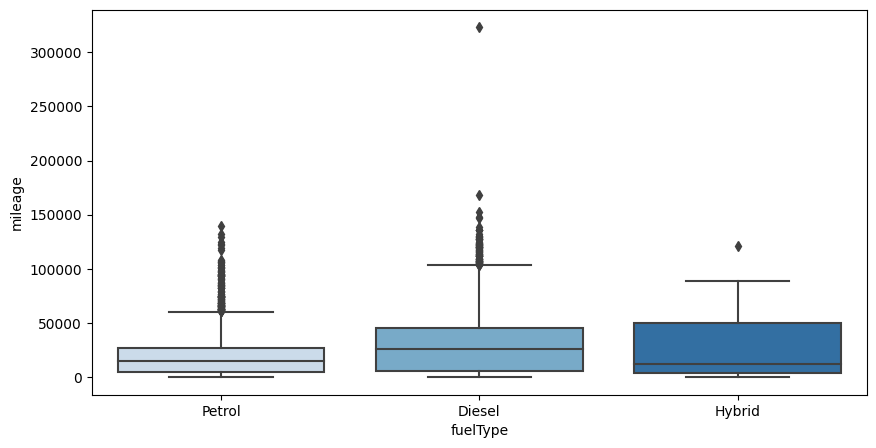

In [71]:
fig = plt.figure(figsize=(10, 5))
sns.boxplot(data = df, y = 'mileage', x = 'fuelType', palette='Blues')

- na grafu lze spatřit, že v průměru mají auta na benzín ujetých méně kilometrů

### Závisí nějak objem motoru na silniční dani?

<AxesSubplot: xlabel='engineSize', ylabel='tax'>

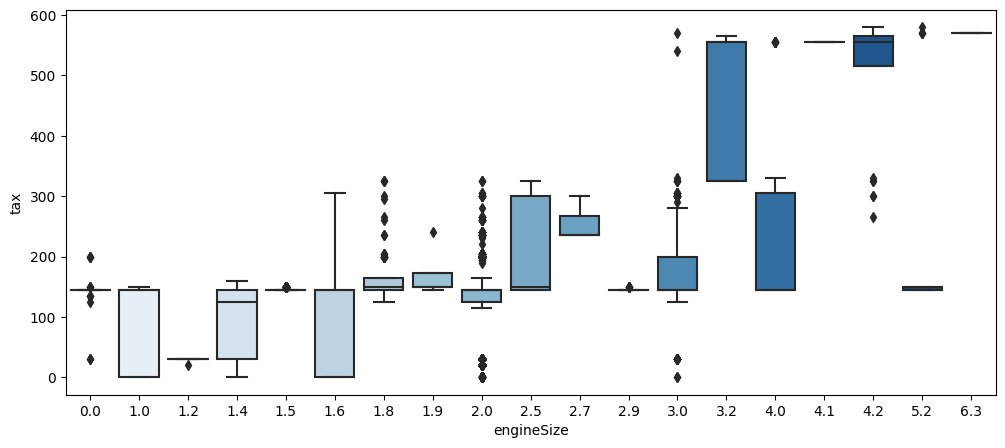

In [72]:
fig = plt.figure(figsize=(12, 5))
sns.boxplot(data = df, y = 'tax', x = 'engineSize', palette='Blues')

- s růstajícím objemem motoru roste i daň

### Závisí nějak objem motoru na spotřebě ojetého auta?

<AxesSubplot: xlabel='engineSize', ylabel='mpg'>

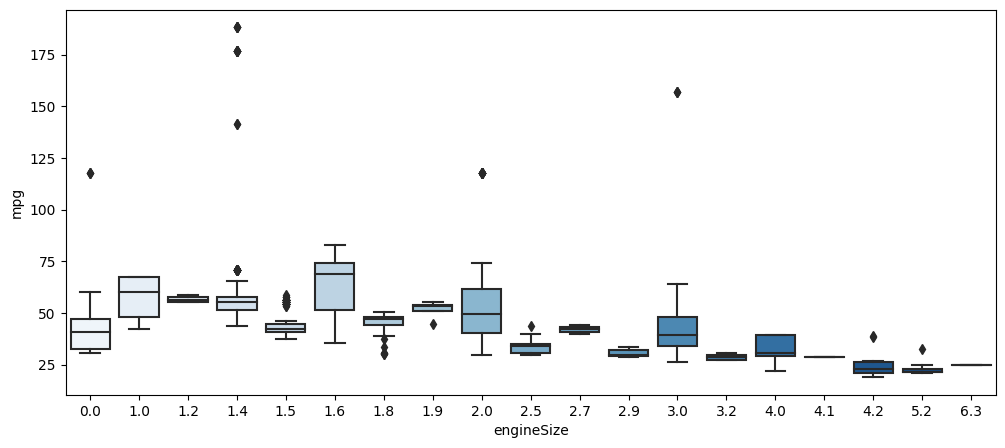

In [73]:
fig = plt.figure(figsize=(12, 5))
sns.boxplot(data = df, y = 'mpg', x = 'engineSize', palette='Blues')

- s rostoucím objemem motoru stoupá i spotřeba paliva

### Závisí nějak objem motoru na ceně ojetého auta?

<AxesSubplot: xlabel='engineSize', ylabel='price'>

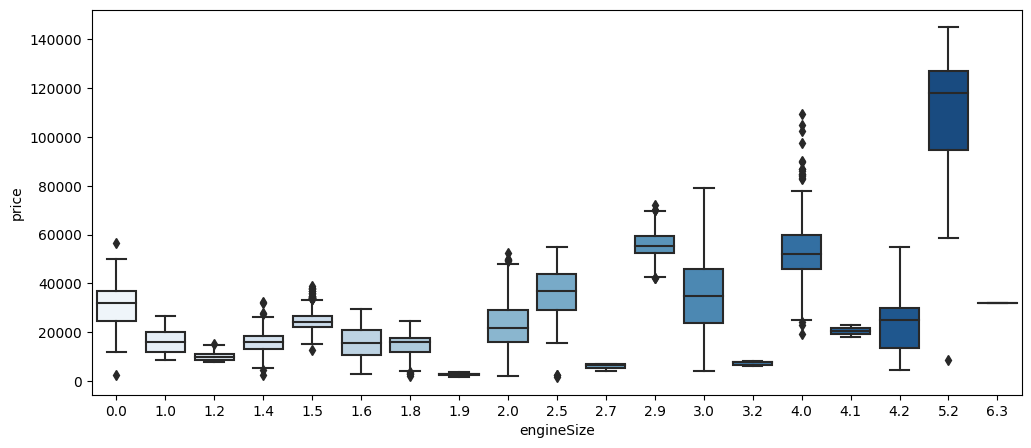

In [74]:
fig = plt.figure(figsize=(12, 5))
sns.boxplot(data = df, y = 'price', x = 'engineSize', palette='Blues')

- auta s větším objemem motoru mají převážně vyšší cenu

### V jakém počtu jsou v tabulce zastoupeny různé objemy motorů?

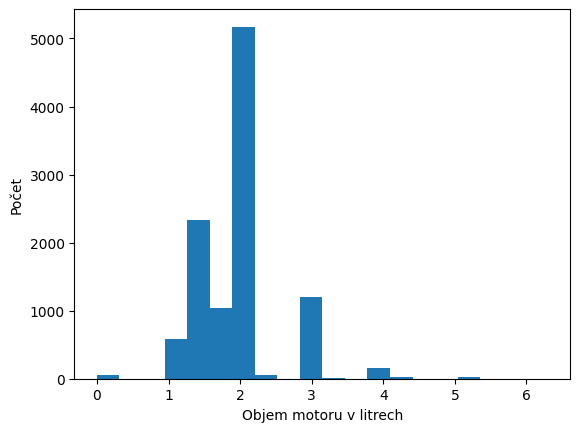

In [75]:
df["engineSize"].hist(grid=False,bins=20)

plt.xlabel("Objem motoru v litrech")
plt.ylabel("Počet")
plt.show()

- převažují auta s objemem motoru kolem 1,5 - 2 litrů

## Task 1 - Pokus o clustering :)

In [6]:
df_encoded = pd.get_dummies(df)
df_encoded

year  price  mileage  tax   mpg  engineSize  transmission_val  \
0      2017  12500    15735  150  55.4         1.4                 0   
1      2016  16500    36203   20  64.2         2.0                 1   
2      2016  11000    29946   30  55.4         1.4                 0   
3      2017  16800    25952  145  67.3         2.0                 1   
4      2019  17300     1998  145  49.6         1.0                 0   
...     ...    ...      ...  ...   ...         ...               ...   
10663  2020  16999     4018  145  49.6         1.0                 0   
10664  2020  16999     1978  150  49.6         1.0                 0   
10665  2020  17199      609  150  49.6         1.0                 0   
10666  2017  19499     8646  150  47.9         1.4                 1   
10667  2016  15999    11855  150  47.9         1.4                 0   

       fuelType_val  model_ A1  model_ A2  model_ A3  model_ A4  model_ A5  \
0                 0          1          0          0          0          0   
1                 1          0          0          0          0          0   
2                 0          1          0          0          0          0   
3                 1          0          0          0          1          0   
4                 0          0          0          1          0          0   
...             ...        ...        ...        ...        ...        ...   
10663             0          0          0          1          0          0   
10664             0          0          0          1          0          0   
10665             0          0          0          1          0          0   
10666             0          0          0          0          0          0   
10667             0          0          0          0          0          0   

       model_ A6  model_ A7  model_ A8  model_ Q2  model_ Q3  model_ Q5  \
0              0          0          0          0          0          0   
1              1          0          0          0          0          0   
2              0          0          0          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
10663          0          0          0          0          0          0   
10664          0          0          0          0          0          0   
10665          0          0          0          0          0          0   
10666          0          0          0          0          1          0   
10667          0          0          0          0          1          0   

       model_ Q7  model_ Q8  model_ R8  model_ RS3  model_ RS4  model_ RS5  \
0              0          0          0           0           0           0   
1              0          0          0           0           0           0   
2              0          0          0           0           0           0   
3              0          0          0           0           0           0   
4              0          0          0           0           0           0   
...          ...        ...        ...         ...         ...         ...   
10663          0          0          0           0           0           0   
10664          0          0          0           0           0           0   
10665          0          0          0           0           0           0   
10666          0          0          0           0           0           0   
10667          0          0          0           0           0           0   

       model_ RS6  model_ RS7  model_ S3  model_ S4  model_ S5  model_ S8  \
0               0           0          0          0          0          0   
1               0           0          0          0          0          0   
2               0           0          0          0          0          0   
3               0           0          0          0        

- aplikace one-hot encodingu na data
- získání dummies pro každý atribut

### K-means algoritmus

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ubuntu/.local/lib/python3.

<AxesSubplot: xlabel='k'>

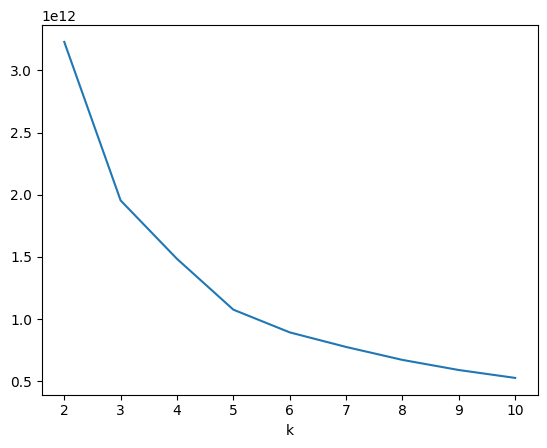

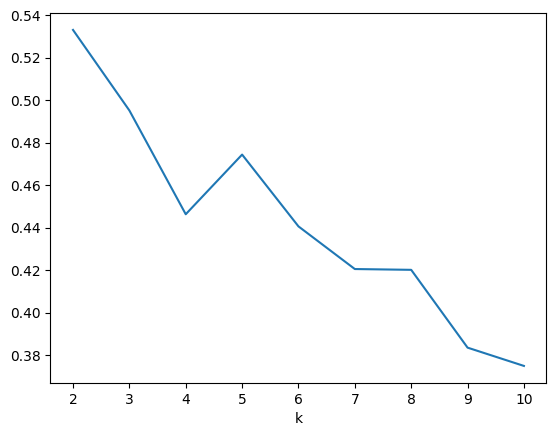

In [77]:
X = df_encoded.values

clustering_scores = []
for k in range(2, 11):
    clustering = sklearn.cluster.KMeans(n_clusters=k).fit(X)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(X, clustering.labels_)
    })
df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')
df_clustering_scores.sse.plot()
plt.figure()
df_clustering_scores.silhouette.plot()

- vhodný počet clusterů spadá přibližně na číslo 3 -> takže budeme mít 3 clustery :-)

### Pojďme se na ně mrknout

#### Vyzkoušení různého počtu clusterů

##### 2 clustery

In [78]:
clustering = sklearn.cluster.KMeans(n_clusters=2)
clustering.fit(X)

pd.Series(clustering.labels_).value_counts()

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    7482
1    3186
dtype: int64

##### 4 clustery

In [79]:
clustering = sklearn.cluster.KMeans(n_clusters=4)
clustering.fit(X)

pd.Series(clustering.labels_).value_counts()

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    4422
2    3465
1    2109
3     672
dtype: int64

##### 5 clusterů

In [80]:
clustering = sklearn.cluster.KMeans(n_clusters=5)
clustering.fit(X)

pd.Series(clustering.labels_).value_counts()

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    4142
2    3296
1    1869
3     742
4     619
dtype: int64

##### 3 clustery

In [81]:
clustering = sklearn.cluster.KMeans(n_clusters=3)
clustering.fit(X)

pd.Series(clustering.labels_).value_counts()

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1    5251
0    4210
2    1207
dtype: int64

- počty nejsou moc vyrovnané v jakémkoli počtu clusterů, budeme se držet 3 clusterů
- zde jsou počty prvků v každém clusteru

In [82]:
df_clustering = df

df_clustering['cluster_id'] = clustering.labels_
df_clustering.head()

model  year  price transmission  mileage fuelType  tax   mpg  engineSize  \
0    A1  2017  12500       Manual    15735   Petrol  150  55.4         1.4   
1    A6  2016  16500    Automatic    36203   Diesel   20  64.2         2.0   
2    A1  2016  11000       Manual    29946   Petrol   30  55.4         1.4   
3    A4  2017  16800    Automatic    25952   Diesel  145  67.3         2.0   
4    A3  2019  17300       Manual     1998   Petrol  145  49.6         1.0   

   transmission_val  fuelType_val  cluster_id  
0                 0             0           0  
1                 1             1           0  
2                 0             0           0  
3                 1             1           0  
4                 0             0           1

- náhled do nové tabulky, kde jsou i čísla clusterů

<AxesSubplot: xlabel='cluster_id', ylabel='count'>

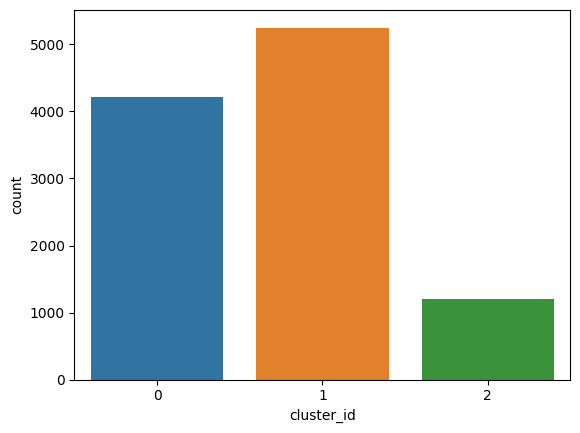

In [83]:
sns.countplot(data=df_clustering, x='cluster_id')

- zobrazení počtu aut v každém clusteru v count plotu

### Vyobrazení clusterů v tabulkách

- clustery nejsou moc vyvážené, ale nedá se říct, že by nebyly vůbec vyvážené

In [84]:
df_clustering.groupby('cluster_id').describe()

year                                                         \
             count         mean       std     min     25%     50%     75%   
cluster_id                                                                  
0           4210.0  2016.013064  1.263020  2003.0  2015.0  2016.0  2017.0   
1           5251.0  2018.683489  1.007397  2013.0  2018.0  2019.0  2019.0   
2           1207.0  2014.008285  2.638206  1997.0  2013.0  2015.0  2016.0   

                     price                                               \
               max   count          mean           std     min      25%   
cluster_id                                                                
0           2019.0  4210.0  17222.076247   5624.473619  4689.0  13495.0   
1           2020.0  5251.0  29895.498572  12118.572631  8600.0  22000.0   
2           2018.0  1207.0  12241.617233   4982.402605  1490.0   8996.5   

                                       mileage                              \
                50%      75%       max   count          mean           std   
cluster_id                                                                   
0           16500.0  19500.0   54990.0  4210.0  32666.803800   9736.924117   
1           27200.0  33940.0  145000.0  5251.0   7136.449057   5400.320728   
2           11600.0  14750.0   40990.0  1207.0  74445.982601  19689.958274   

                                                              tax              \
                min      25%      50%       75%       max   count        mean   
cluster_id                                                                      
0           13854.0  24768.0  31289.0  40073.75   55500.0  4210.0  107.218527   
1               1.0   3137.0   5799.0  10207.50   35000.0  5251.0  144.488669   
2           53291.0  59890.0  69212.0  83467.50  323000.0  1207.0  111.176471   

                                                            mpg             \
                   std  min    25%    50%    75%    max   count       mean   
cluster_id                                                                   
0            78.443865  0.0   30.0  145.0  150.0  580.0  4210.0  56.808005   
1            31.204859  0.0  145.0  145.0  145.0  580.0  5251.0  44.197334   
2           106.078444  0.0   20.0  125.0  160.0  570.0  1207.0  58.303811   

                                                     engineSize            \
                  std   min   25%   50%   75%    max      count      mean   
cluster_id                                                                  
0           11.600440  21.0  49.6  56.5  64.2  188.3     4210.0  1.849834   
1            9.847396  19.6  38.2  42.8  49.6  188.3     5251.0  1.965816   
2           14.808929  18.9  48.7  58.9  67.3  188.3     1207.0  2.060066   

                                              transmission_val            \
                 std  min  25%  50%  75%  max            count      mean   
cluster_id                                                                 
0           0.543246  0.0  1.4  2.0  2.0  6.3           4210.0  0.752494   
1           0.656506  0.0  1.5  2.0  2.0  5.2           5251.0  1.143973   
2           0.514270  0.0  2.0  2.0  2.0  5.2           1207.0  0.592378   

                                              fuelType_val            \
                 std  min  25%  50%  75%  max        count      mean   
cluster_id                                                             
0           0.880358  0.0  0.0  0.0  2.0  2.0       4210.0  0.529216   
1           0.806776  0.0  0.0  1.0  2.0  2.0       5251.0  0.456294   
2           0.769145  0.0  0.0  0.0  1.0  2.0       1207.0  0.835957   

                                               
                 std  min  25%  50%  75%  max  
cluster_id                                     
0           0.502525  0.0  0.0  1.0  1.0  2.0  
1           0.503837  0.0  0.0  0.0  1.0  2.0  
2           0.383662  0.0  1.0  1.0  1.0  2.0

- v této tabulce lze spatřit jaké jsou různé průměry, maxima a minima (a další) pro každý atribut v každém clusteru
- rozděleno na 3 clustery, které se liší hlavně průměrnou cenou auta, máme je rozdělené do cenových kategorií
- v největším clusteru jsou auta s největší průměrnou cenou, nejnižší najetou vzdáleností, ale i nejnižší spotřebou

In [85]:
df_clustering.groupby('cluster_id').describe(include='O')

model                  transmission                          \
           count unique  top freq        count unique        top  freq   
cluster_id                                                               
0           4210     23   A3  847         4210      3     Manual  2281   
1           5251     23   A3  798         5251      3  Semi-Auto  2141   
2           1207     22   A3  284         1207      3     Manual   703   

           fuelType                       
              count unique     top  freq  
cluster_id                                
0              4210      3  Diesel  2214  
1              5251      3  Petrol  2870  
2              1207      3  Diesel   997

- zde jsou vyobrazeny pouze datové typy `object`
- ve všech clusterech je nejčastější model "A3"

### Jak se pohybují ceny v našich clusterech?

<AxesSubplot: xlabel='cluster_id', ylabel='price'>

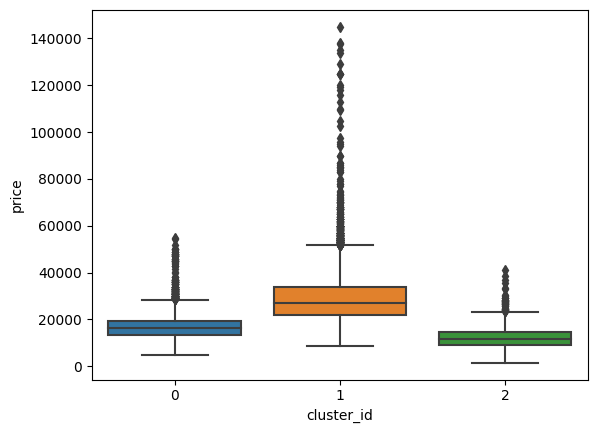

In [86]:
sns.boxplot(data=df_clustering, y='price', x='cluster_id')

- v druhém clusteru jsou velice různé ceny, obecně jsou vyšší než v obou ostatních clusterech

### Jak se pohybují ujeté vzdálenosti v našich clusterech?

<AxesSubplot: xlabel='cluster_id', ylabel='mileage'>

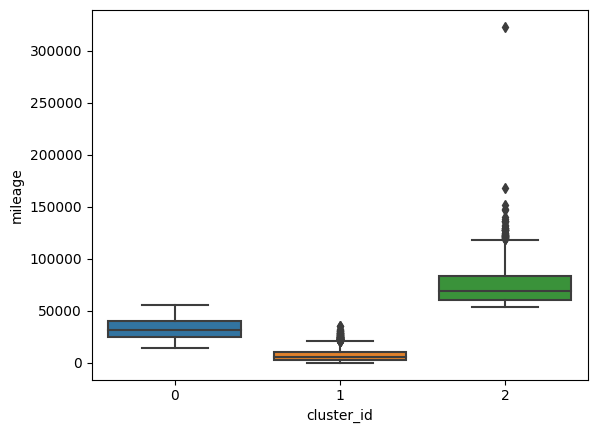

In [87]:
sns.boxplot(data=df_clustering, y='mileage', x='cluster_id')

- máme tři různé kategorie ujetých vzdáleností
- v clusteru, kde máme nejvyšší průměrné ceny, máme nejnižší najeté vzdálenosti

### Jaké modely aut jsou nejvíce zastoupeny v našich clusterech?

<AxesSubplot: xlabel='model', ylabel='count'>

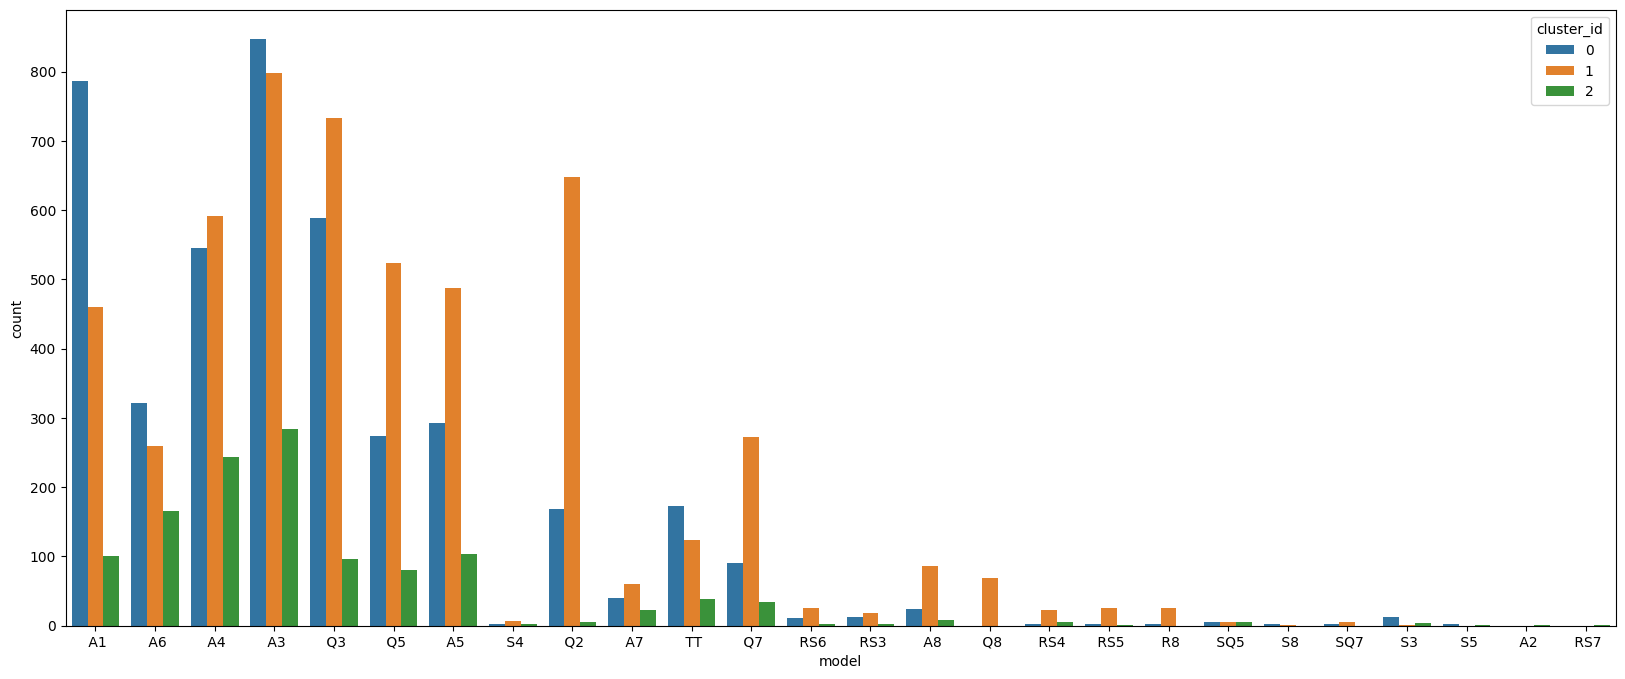

In [88]:
plt.figure(figsize=(20,8))
sns.countplot(data=df_clustering, x='model', hue='cluster_id')

- graf znázorňující zastoupení jednotlivých modelů aut v každém clusteru
- model A3 je nejčastější ve všech clusterech

### Jaké registrace aut jsou nejvíce zastoupeny v našich clusterech?

<AxesSubplot: xlabel='year', ylabel='count'>

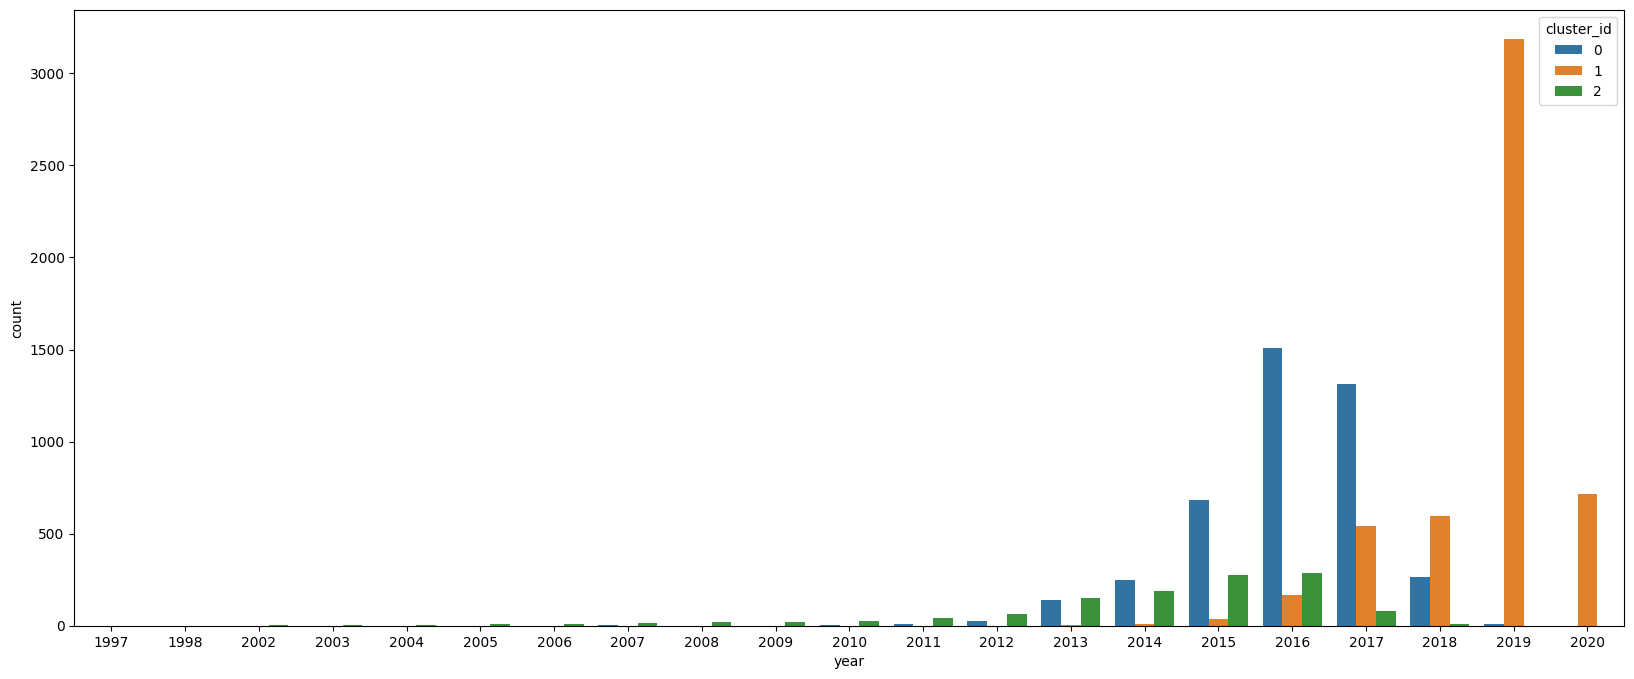

In [89]:
plt.figure(figsize=(20,8))
sns.countplot(data=df_clustering, x='year', hue='cluster_id')

- lze spatřit, že:
    - cluster 2 obsahuje převážně auta s nízkým rokem registrace
    - cluster 0 obsahuje převážně registrace mezi 2013 - 2018
    - cluster 1 obsahuje převážně novější registrace

### Jaká jsou nejdražší auta v každém clusteru?

In [90]:
df_clustering.loc[df_clustering.cluster_id == 0].sort_values(by="price", ascending=False).head(5)

model  year  price transmission  mileage fuelType  tax   mpg  engineSize  \
4797   RS6  2017  54990    Automatic    39300   Petrol  145  29.4         4.0   
4494   RS6  2017  54490    Semi-Auto    39300   Petrol  145  29.4         4.0   
7014   RS6  2017  52000    Semi-Auto    47501   Petrol  145  29.4         4.0   
2178    Q7  2017  49995    Semi-Auto    39300   Diesel  150  39.2         4.0   
4427   RS4  2018  49990    Semi-Auto    33827   Petrol  145  32.1         2.9   

      transmission_val  fuelType_val  cluster_id  
4797                 1             0           0  
4494                 2             0           0  
7014                 2             0           0  
2178                 2             1           0  
4427                 2             0           0

In [91]:
df_clustering.loc[df_clustering.cluster_id == 1].sort_values(by="price", ascending=False).head(5)

model  year   price transmission  mileage fuelType  tax   mpg  \
4783    R8  2020  145000    Semi-Auto     2000   Petrol  145  21.1   
2255    R8  2020  137995    Semi-Auto       70   Petrol  145  21.1   
4179    R8  2019  137500    Semi-Auto       10   Petrol  150  21.4   
3367    R8  2019  135000    Automatic     1000   Petrol  145  32.8   
5459    R8  2020  133900    Semi-Auto      333   Petrol  145  21.4   

      engineSize  transmission_val  fuelType_val  cluster_id  
4783         5.2                 2             0           1  
2255         5.2                 2             0           1  
4179         5.2                 2             0           1  
3367         5.2                 1             0           1  
5459         5.2                 2             0           1

In [92]:
df_clustering.loc[df_clustering.cluster_id == 2].sort_values(by="price", ascending=False).head(5)

model  year  price transmission  mileage fuelType  tax   mpg  \
4967    RS6  2014  40990    Automatic    63476   Petrol  555  28.8   
10433   RS6  2014  38444    Automatic    58000   Petrol  555  28.8   
4125    RS6  2014  37000    Automatic    59894   Petrol  555  28.8   
3688     TT  2017  35500    Semi-Auto    56470   Petrol  145  34.5   
10187   RS7  2014  33490    Automatic    56000   Petrol  555  28.8   

       engineSize  transmission_val  fuelType_val  cluster_id  
4967          4.0                 1             0           2  
10433         4.0                 1             0           2  
4125          4.0                 1             0           2  
3688          2.5                 2             0           2  
10187         4.0                 1             0           2

- v druhém clusteru jsou auta vyšší cenové třídy a mají velmi málo najeto
- v prvním a třetím clusteru jsou auta podobné cenové třídy

## Pokus o aglomerativní clustering :-)

### Příprava na clustering

### Příprava dat, clustering podle sloupců `price` a `mileage`

In [25]:
x=df_encoded.iloc[:,[1,2]].values
x.shape

(10668, 2)

### Vytvoření dendogramu znázorňující clustery (použita ward methoda)

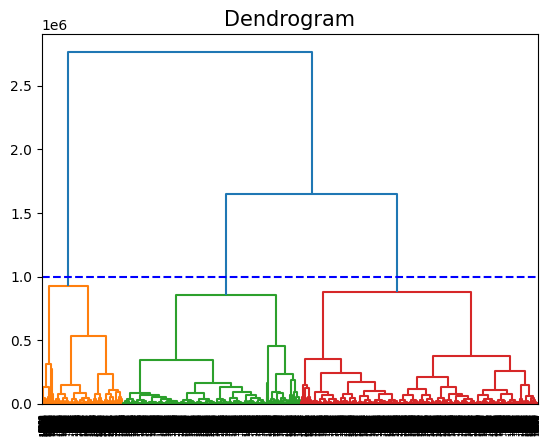

In [26]:
dendrogram = clust_hier.dendrogram(clust_hier.linkage(x, method = 'ward'), color_threshold=1000000)
plt.title('Dendrogram', fontsize = 15)
plt.axhline(y = 1000000, color = 'b', linestyle = '--')
plt.show()

### Vytvoření různého množství clusterů

- nejlepší možnost jsou asi 3 clustery, 2 jsou málo a více clusterů nejsou moc dobře vyrovnané

##### 4 clustery

In [28]:
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(x)
pd.Series(hc.labels_).value_counts()

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


0    5087
2    3834
1    1490
3     257
dtype: int64

##### 5 clusterů

In [29]:
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(x)
pd.Series(hc.labels_).value_counts()

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


0    3834
2    2997
4    2090
1    1490
3     257
dtype: int64

##### 2 clustery

In [30]:
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(x)
pd.Series(hc.labels_).value_counts()

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


0    8921
1    1747
dtype: int64

##### 3 clustery

In [31]:
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(x)
print(pd.Series(hc.labels_).value_counts())

df_clustering = df
df_clustering['cluster_id'] = hc.labels_

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


1    5087
2    3834
0    1747
dtype: int64


### Vyobrazení scatter plotu při 3 clusterech

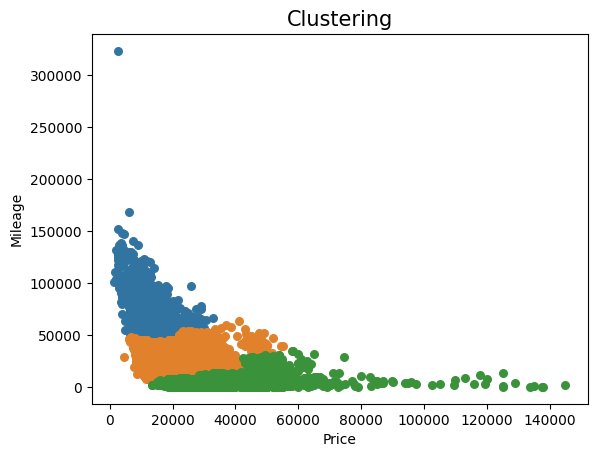

In [33]:
plt.scatter(x[y_hc == 0, 0], x[y_hc == 0, 1], s = 30, c = '#3274a1')
plt.scatter(x[y_hc == 1, 0], x[y_hc == 1, 1], s = 30, c = '#e1812c')
plt.scatter(x[y_hc == 2, 0], x[y_hc == 2, 1], s = 30, c = '#3a923a')
plt.title('Clustering', fontsize = 15)
plt.xlabel('Price')
plt.ylabel('Mileage')
plt.show()

- na tomto grafu lze spatřit, že máme hodnoty správné "odclusterované" podle ceny/ujetá vzdálenost, máme 3 kategorie

### Kolik hodnot je v každém clusteru?

<AxesSubplot: xlabel='cluster_id', ylabel='count'>

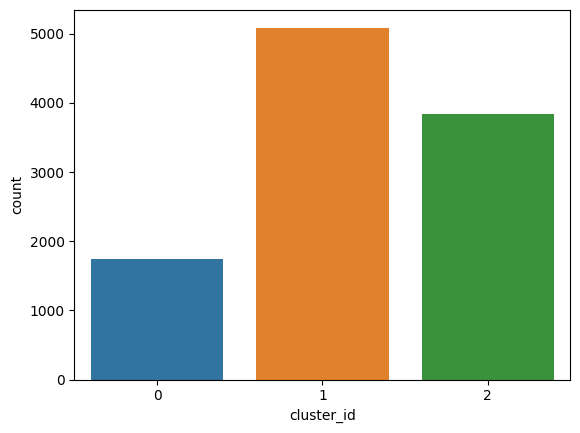

In [34]:
sns.countplot(data=df_clustering, x='cluster_id')

### Popis číselných hodnot v každém clusteru

In [35]:
df_clustering.groupby('cluster_id').describe()

year                                                         \
             count         mean       std     min     25%     50%     75%   
cluster_id                                                                  
0           1747.0  2014.404121  2.386326  1997.0  2014.0  2015.0  2016.0   
1           5087.0  2016.543346  1.362681  2003.0  2016.0  2017.0  2017.0   
2           3834.0  2019.068858  0.644433  2013.0  2019.0  2019.0  2019.0   

                     price                                                \
               max   count          mean           std      min      25%   
cluster_id                                                                 
0           2018.0  1747.0  12914.223812   4443.933468   1490.0   9921.0   
1           2020.0  5087.0  18874.873993   6130.293040   4689.0  14799.5   
2           2020.0  3834.0  32781.482264  12587.397322  13495.0  24882.0   

                                       mileage                              \
                50%      75%       max   count          mean           std   
cluster_id                                                                   
0           12745.0  15699.5   32998.0  1747.0  66467.752147  20300.793368   
1           17998.0  21688.0   54990.0  5087.0  25594.581875  10401.911464   
2           29990.0  36442.5  145000.0  3834.0   4835.221179   3925.545629   

                                                              tax              \
                min       25%      50%      75%       max   count        mean   
cluster_id                                                                      
0           43605.0  51503.50  60599.0  76439.5  323000.0  1747.0  105.323412   
1            4520.0  17004.50  25204.0  33515.0   63476.0  5087.0  117.098486   
2               1.0   2388.25   4500.0   6001.0   35000.0  3834.0  147.263954   

                                                            mpg             \
                  std   min    25%    50%    75%    max   count       mean   
cluster_id                                                                   
0           96.519892   0.0   20.0  125.0  160.0  570.0  1747.0  58.539496   
1           72.081127   0.0   30.0  145.0  150.0  580.0  5087.0  54.844545   
2           25.809103  20.0  145.0  145.0  145.0  580.0  3834.0  41.823657   

                                                     engineSize            \
                  std   min   25%   50%   75%    max      count      mean   
cluster_id                                                                  
0           14.257861  18.9  50.0  58.9  67.3  188.3     1747.0  1.998454   
1           11.250105  21.0  47.9  54.3  61.4  188.3     5087.0  1.821899   
2            8.749061  19.6  37.2  40.9  47.9  141.3     3834.0  2.044210   

                                              transmission_val            \
                 std  min  25%  50%  75%  max            count      mean   
cluster_id                                                                 
0           0.476423  0.0  1.8  2.0  2.0  5.2           1747.0  0.646251   
1           0.550194  0.0  1.4  2.0  2.0  6.3           5087.0  0.834480   
2           0.689929  0.0  1.6  2.0  2.0  5.2           3834.0  1.177882   

                                              fuelType_val            \
                 std  min  25%  50%  75%  max        count      mean   
cluster_id                                                             
0           0.807817  0.0  0.0  0.0  1.0  2.0       1747.0  0.798512   
1           0.892869  0.0  0.0  1.0  2.0  2.0       5087.0  0.447022   
2           0.772385  0.0  1.0  1.0  2.0  2.0       3834.0  0.512259   

                                               
                 std  min  25%  50%  75%  max  
cluster_id                                     
0           0.413875  0.0  1.0  1.0  1.0  2.0  
1           0.499207  0.0  0.0  0.0  1.0  2.0  
2           0.507169  0.0  0.0  1.0  1.0  2.0

- v největším clusteru jsou převážně jsou auta "středního" věku - ani stará, ani mladá, jedná se o cluster jakési střední kategorie

### Popis kategorických hodnot v každém clusteru

In [36]:
df_clustering.groupby('cluster_id').describe(include='O')

model                   transmission                          \
           count unique  top  freq        count unique        top  freq   
cluster_id                                                                
0           1747     20   A3   404         1747      3     Manual   988   
1           5087     24   A3  1059         5087      3     Manual  2518   
2           3834     22   Q3   536         3834      3  Semi-Auto  1545   

           fuelType                       
              count unique     top  freq  
cluster_id                                
0              1747      3  Diesel  1377  
1              5087      3  Petrol  2818  
2              3834      3  Diesel  1936

### Jaké jsou ceny v jednotlivých clusterech?

<AxesSubplot: xlabel='cluster_id', ylabel='price'>

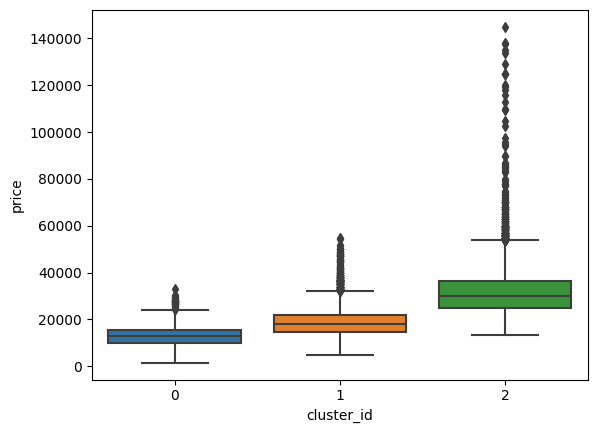

In [37]:
sns.boxplot(data=df_clustering, y='price', x='cluster_id')

- výsledek je velice podobný až stejný jako u k-means algoritmu
- máme tři různé cenové kategorie
- ve třetím clusteru jsou velice různé ceny, obecně jsou vyšší než v obou ostatních clusterech
- první cluster obsahuje nižší ceny než ostatní

### Jaké jsou ujeté vzdálenosti v našich clusterech?

<AxesSubplot: xlabel='cluster_id', ylabel='mileage'>

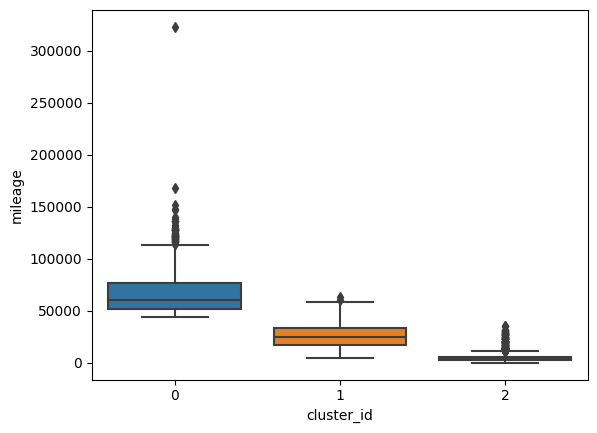

In [38]:
sns.boxplot(data=df_clustering, y='mileage', x='cluster_id')

- máme tři různé kategorie ujetých vzdáleností
- souvislost s předchozím grafem - třetí cluster obsahoval dražší auta - to protože se jedná o auta, která mají málo najeto

### Jaké modely jsou nejvíce zastoupeny v každém clusteru? 

<AxesSubplot: xlabel='model', ylabel='count'>

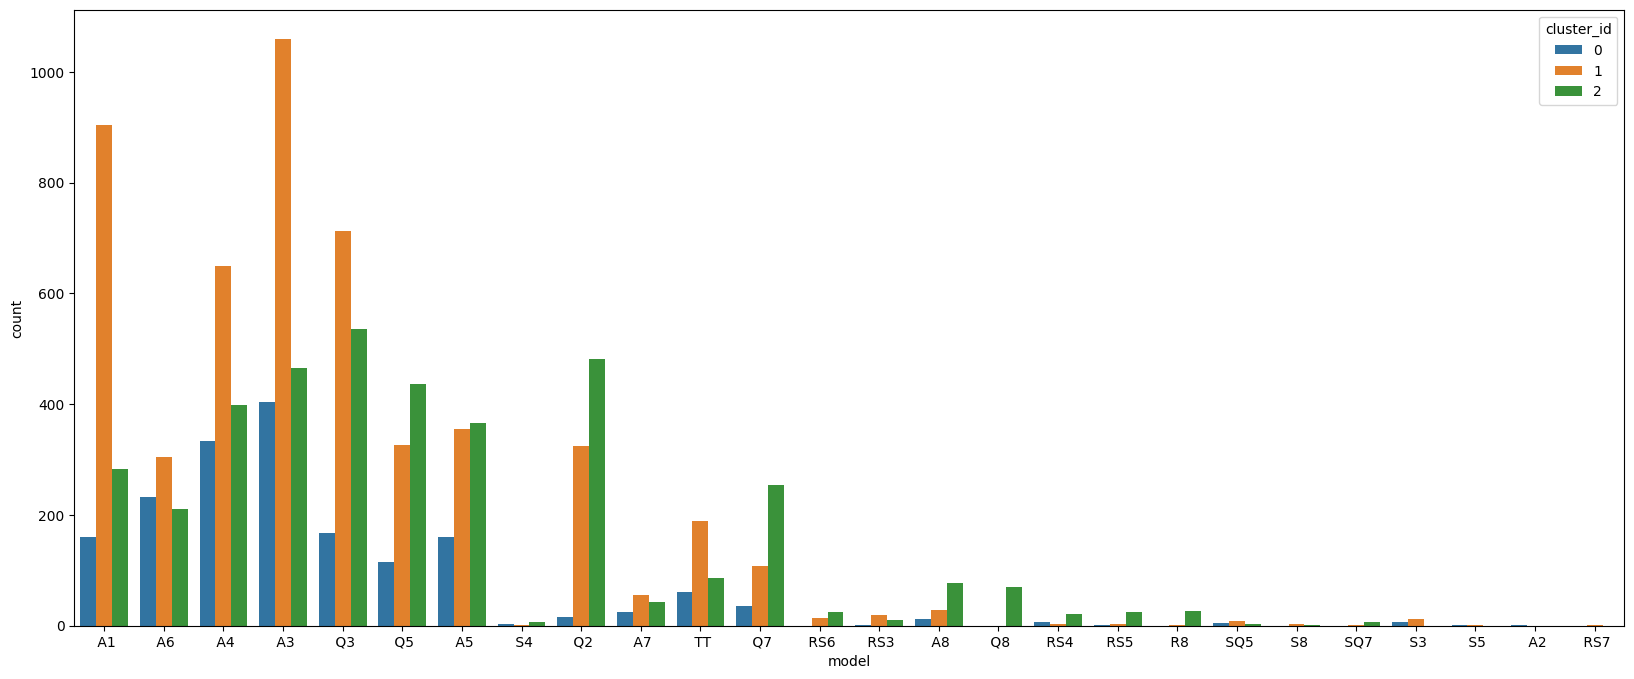

In [39]:
plt.figure(figsize=(20,8))
sns.countplot(data=df_clustering, x='model', hue='cluster_id')

- graf znázorňující zastoupení jednotlivých modelů aut v každém clusteru
- vychází trochu odlišně oproti k-means algoritmu

### Jaké registrace nejvíce převažují v každém clusteru?

<AxesSubplot: xlabel='year', ylabel='count'>

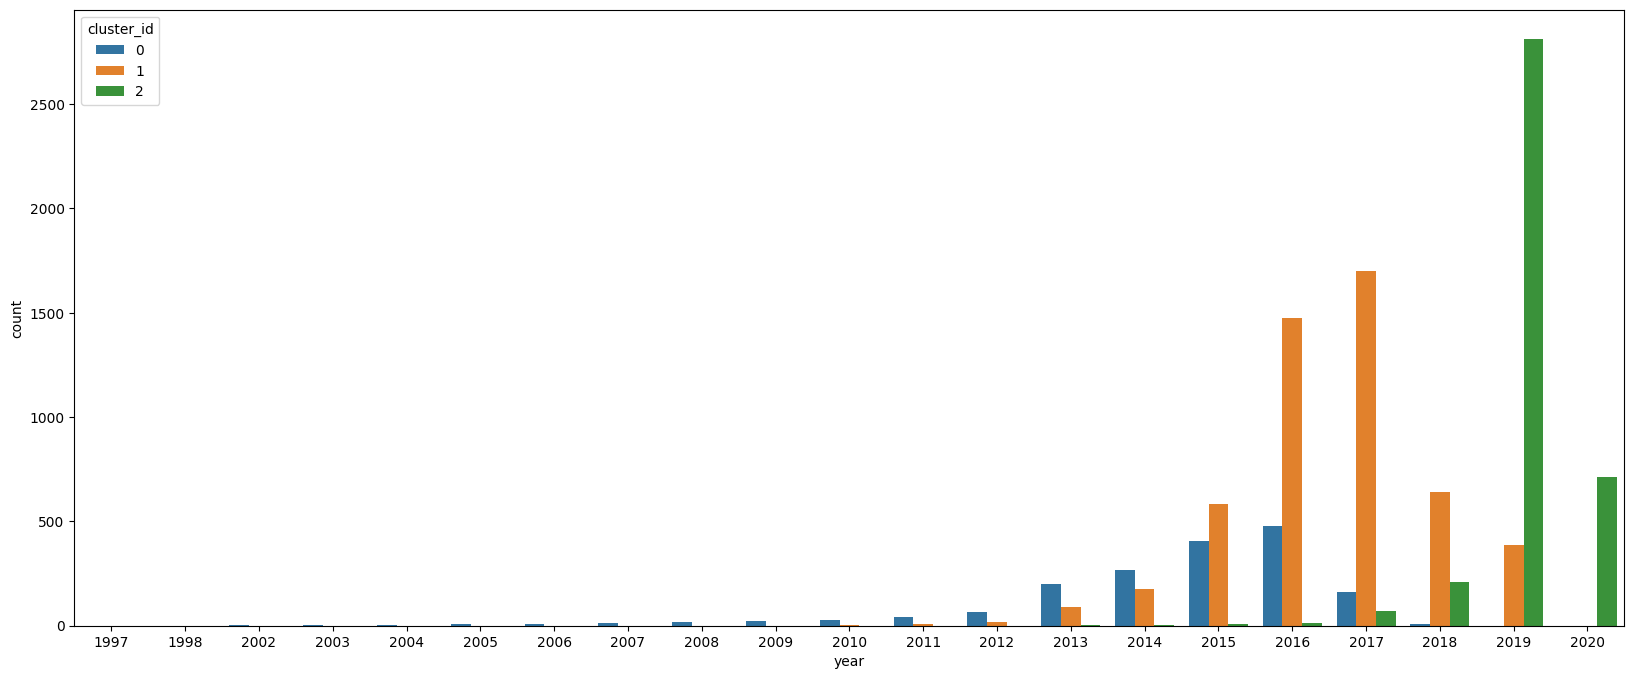

In [40]:
plt.figure(figsize=(20,8))
sns.countplot(data=df_clustering, x='year', hue='cluster_id')

- výsledek je velice podobný jako k-means algoritmus
- lze spatřit, že:
    - cluster 0 obsahuje převážně auta s nízkým rokem registrace
    - cluster 1 obsahuje převážně registrace mezi 2013 - 2018
    - cluster 2 obsahuje převážně novější registrace

### Jaká jsou nejdražší auta v každém clusteru?

In [41]:
df_clustering.loc[df_clustering.cluster_id == 0].sort_values(by="price", ascending=False).head(5)

model  year  price transmission  mileage fuelType  tax    mpg  \
2550    Q7  2017  32998    Semi-Auto    66477   Hybrid  140  156.9   
5246    Q7  2016  30490    Semi-Auto    64460   Diesel  200   47.9   
5782    Q7  2016  29990    Semi-Auto    57000   Diesel  200   47.9   
4410    Q7  2016  28990    Semi-Auto    74840   Diesel  205   47.9   
6787    Q7  2016  28990    Semi-Auto    65019   Diesel  200   47.9   

      engineSize  transmission_val  fuelType_val  cluster_id  
2550         3.0                 2             2           0  
5246         3.0                 2             1           0  
5782         3.0                 2             1           0  
4410         3.0                 2             1           0  
6787         3.0                 2             1           0

In [42]:
df_clustering.loc[df_clustering.cluster_id == 1].sort_values(by="price", ascending=False).head(5)

model  year  price transmission  mileage fuelType  tax   mpg  engineSize  \
4797   RS6  2017  54990    Automatic    39300   Petrol  145  29.4         4.0   
4494   RS6  2017  54490    Semi-Auto    39300   Petrol  145  29.4         4.0   
7014   RS6  2017  52000    Semi-Auto    47501   Petrol  145  29.4         4.0   
7048    Q7  2017  51500    Semi-Auto    32568   Diesel  145  39.2         4.0   
2178    Q7  2017  49995    Semi-Auto    39300   Diesel  150  39.2         4.0   

      transmission_val  fuelType_val  cluster_id  
4797                 1             0           1  
4494                 2             0           1  
7014                 2             0           1  
7048                 2             1           1  
2178                 2             1           1

In [43]:
df_clustering.loc[df_clustering.cluster_id == 2].sort_values(by="price", ascending=False).head(5)

model  year   price transmission  mileage fuelType  tax   mpg  \
4783    R8  2020  145000    Semi-Auto     2000   Petrol  145  21.1   
2255    R8  2020  137995    Semi-Auto       70   Petrol  145  21.1   
4179    R8  2019  137500    Semi-Auto       10   Petrol  150  21.4   
3367    R8  2019  135000    Automatic     1000   Petrol  145  32.8   
5459    R8  2020  133900    Semi-Auto      333   Petrol  145  21.4   

      engineSize  transmission_val  fuelType_val  cluster_id  
4783         5.2                 2             0           2  
2255         5.2                 2             0           2  
4179         5.2                 2             0           2  
3367         5.2                 1             0           2  
5459         5.2                 2             0           2

- v prvním clusteru jsou auta v nižší cenové třídě
- v druhém clusteru jsou auta střední cenové třídy
- ve třetím clusteru jsou auta vyšší cenové třídy a mají velmi málo najeto

# Závěr


Dataset obsahuje data ojetých aut v jakémsi Audi dealerství. Máme zde vcelku hodně záznamů, avšak jen pár atributů. Některé kategorické atributy jsem si převedl na číselné hodnoty, které v některých případech usnadnily práci.

Poté jsme provedli clustering dle K-Means algoritmu a Aglomerative clustering, výsledky z K-Means se mi zdály vyváženější oproti aglomerativnímu

V datasetu jsem nalezl takové postřehy, které odpovídají realitě a i některým mým předtuchám (zvýrazněno tučně).

Zde jsou získané poznatky:
 - průměrná cena ojetého auta je `22,8 tisíc` eur
 - průměrná ujetá vzdálenost auta je `24,8 tisíc` mil
 - nejdražší ojeté auto je model `R8` s cenou `145 tisíc` eur a najetou vzdáleností `2000` mil
 - **nejdražší auta jsou v průměru ta, která mají velký objem motoru**
 - **naopak nejlevnější auta jsou v průměru ta, která mají velké najeté vzdálenosti**
 - nejdražší auta jsou z velké většiny `benzínová`
 - nejvíce nabízený model je `A3`
 - `benzínové` a `dieselové` motory jsou vyvážené, žádný z nich nepřevažuje
 - tabulka obsahuje nějaké slabší závislosti
   - čím větší je objem motoru, tím bývá větší cena
   - cena také slabě závisí na typu převodovky
 - u automatické převodovky mají větší zastoupení dieselové motory, u jiných převodovek je poměr vyvážený
 - `hybridní` auta jsou nabízena velmi málo
 - `hybridní` auta mají nejlepší spotřeby, mají ale celkem slabé motory (`engineSize`)
 - `benzínová` auta mají v průměru najetou menší vzdálenost
 - **lze spatřit, že s roustoucím objemem motoru roste i silniční daň (pravděpodobně kvůli roustoucí spotřebě)**
 - **s rostoucím objemem motoru roste i spotřeba paliva**

Získané poznatky z clusteringu:
 - postřehy z obou algoritmů jsou vcelku podobné
 - cenové kategorie jsou trochu výraznější v aglomerative oproti K-Means (mají o trochu méně výrazných outlierů)
 - výsledky v obou "clusterování" byly na podobné úrovni vyváženosti
 - aglomerative clustering byl především zaměřen na rozdělení podle `price`/`mileage`
 - Obecné postřehy z K-Means:
   - rozděleno na 3 clustery, které se liší hlavně průměrnou cenou auta, máme je rozdělené do cenových kategorií
   - všechny tři clustery mají různé velikosti, bývá to často největší cluster, menší a nejmenší - nejsou vyvážené
   - v největším clusteru u K-Means jsou auta s největší průměrnou cenou, nejnižší najetou vzdáleností, ale i nejnižší spotřebou
   - v clusteru, kde máme nejvyšší průměrné ceny, máme nejnižší najeté vzdálenosti - což odpovídá realitě
   - ve všech clusterech u K-Means je nejčastější model `A3`
 - Obecné postřehy z aglomerative:
   - rozděleno na 3 clustery, které znázorňují skupiny podle `price`/`mileage`
   - všechny tři clustery mají různé velikosti, bývá to často největší cluster, menší a nejmenší - nejsou moc vyvážené
   - v největším clusteru u aglomerative jsou auta ve střední třídě (podle `price`, ujeté vzdálenost - `mileage`, roku registrace...)
   - v clusterech u aglomerative je nejčastější model `A3` kromě clusteru vyšší třídy, kde byl model `Q3`
   - v clusteru, kde máme nejvyšší průměrné ceny, máme nejnižší najeté vzdálenosti - což odpovídá realitě, také jsou ceny vcelku různé, pohybují se po velkém intervalu